In [1]:
#In questo codice importiamo un frame di timpix e visualizziamo ed elaboriamo i suoi dati
file_dati_dir='/content/gdrive/My Drive/I01cosmici/' #frame integrale
file_dati='frame_00000.txt' #frame integrale
Nevts  =     1                             #numero di eventi (frame) integrati
Time   =   100                             #finestra temporale del frame
Area   = (0.0055*256)*(0.0055*256)        #area attiva di timepix in cm2
Nruns  =   100
Nrun0  =     0

#Montiamo il my drive in modo da poter accedere ai file caricati senza prompt
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
#Importiamo le librerie di python che ci servono
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
from   scipy.optimize    import curve_fit
from   skimage.measure   import label, regionprops
import matplotlib.pyplot as plt
import numpy as np
from   scipy.stats import linregress

In [3]:
#Clusterizziamo i pixel accesi del frame integrale.

#Un cluster e' un insieme di pixel accesi adiacenti.

#I pixel adiacenti sono quelli che differiscono al più per una riga o per una colonna,
#quindi ogni pixel ha 8 pixel adiacenti:
#sopra,sotto, destra, sinistra, diag destra sopra, diag destra sotto,
#diag sinistra sopra, diag destra sopra.

############################################################
#Per la clusterizzazione si usano due funzioni: "find_neighbors" e "group_non_zero_elements"

def find_neighbors(matrix, i, j, visited):
    neighbors = []
    rows = len(matrix)
    cols = len(matrix[0])
    for x in range(max(0, i-1), min(rows, i+2)):
        for y in range(max(0, j-1), min(cols, j+2)):
            if (x, y) != (i, j) and (x, y) not in visited and matrix[x][y] != 0:
                neighbors.append((x, y))
    return neighbors

def group_non_zero_elements(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    visited = set()
    groups = []
    #Effettivo codice di clusterizzazione: Loop su righe e colonne per clusterizzare.
    for i in range(rows):
        for j in range(cols):
            if (i, j) not in visited and matrix[i][j] != 0:
                stack = [(i, j)]
                group = []
                while stack:
                    x, y = stack.pop()
                    if (x, y) not in visited:
                        visited.add((x, y))
                        group.append((x, y, matrix[x][y]))
                        stack.extend(find_neighbors(matrix, x, y, visited))
                groups.append(group)

    return groups



In [4]:
##########################################################
#Definiamo una funzione che eliminia i pixel rumorosi e
#già che ci siamo anche i pixel con troppa bassa energia

#Funzione che annulla gli elementi di una matrice con valore sopra soglia
def annulla_elementi_superiori_a_soglia(matrix, soglia):
    # Crea una copia della matrice per mantenere l'originale invariata
    matrix_copia = matrix.copy()
    # Annulla tutti gli elementi superiori alla soglia
    matrix_copia[matrix_copia > soglia] = 0
    return matrix_copia
#Funzione che annulla gli elementi di una matrice con valore sopra soglia
def annulla_elementi_inferiori_a_soglia(matrix, soglia):
    # Crea una copia della matrice per mantenere l'originale invariata
    matrix_copia = matrix.copy()
    # Annulla tutti gli elementi superiori alla soglia
    matrix_copia[matrix_copia < soglia] = 0
    return matrix_copia
###########################################################


colors = [(1, 1, 1)] + plt.cm.jet(np.linspace(0, 1, 1000)).tolist()
cmap = mcolors.ListedColormap(colors)



In [5]:
# Create three empty lists
vector_Energy_Tot = []
vector_Col_Tot = []
vector_Row_Tot = []
vector_Rate = []

matrix_Ene    = np.zeros((256, 256))
matrix_Counts = np.zeros((256, 256))
ClusterSize_Counts = np.zeros((25600))
clustersmatrix=np.zeros((25600,256,256))

icluster= 0
newrate = 0
oldrate = 0

for i in range(Nrun0,Nrun0+Nruns):
    oldrate = newrate
    formatted_number = f"{i:05d}"

    #file_dati=file_dati_dir+file_dati
    file_dati=file_dati_dir+"frame_"+str(formatted_number)+".txt"
    #Carica la matrice scritta nel file testo in una matrice (array 2D) di python
    input_matrix     = np.loadtxt(file_dati, delimiter=' ')
    print("File",file_dati,"caricato nella matrice input_matrix")

    #Azzeriamo i pixel non voluti
    Soglia_Pixel_Rumorosi=300
    Soglia_Pixel_SottoSoglia=0
    input_matrix     = annulla_elementi_superiori_a_soglia(input_matrix,Soglia_Pixel_Rumorosi)
    input_matrix     = annulla_elementi_inferiori_a_soglia(input_matrix,Soglia_Pixel_SottoSoglia)
    #Riduciamo eventualmente la grandezza della matrice
    row_first =  0
    row_last  =256
    col_first =  0
    col_last  =256
    input_matrix     = input_matrix[row_first:row_last,col_first:col_last]
    #print("Eliminati i pixel rumorosi con energia superiore a", Soglia_Pixel_Rumorosi, "e pixel di energia inferiore a",Soglia_Pixel_SottoSoglia)


    clusters_result = group_non_zero_elements(input_matrix)
    #print("Sono stati trovati",clusters_result,"clusters.")
    #print("I clusters sono descritti dall'array di tre dimensioni clusters_result.")
    #Per ogni cluster determino energia totale, colonna media pesata dall'energia
    # e riga media pesata dall'energia e sono
    #descritti nei tre vettori : vector_Energy_Tot, vector_Col_Tot, vector_Row_Tot.
    #Inoltre conto i cluster che hanno N pixel nel vettore ClusterSize_Counts.


    for group in clusters_result:
        icluster += 1
        #print(icluster,group,len(group))
        cluster_size=len(group)
        ClusterSize_Counts  [cluster_size] =  ClusterSize_Counts  [cluster_size] + 1

        Energy_Tot=0
        col       =0
        row       =0
        for pixel in group:
            #print(icluster,pixel)
            col = col+pixel[1]*pixel[2]
            row = row+pixel[0]*pixel[2]
            Energy_Tot=Energy_Tot+pixel[2]
            vector_Energy_Tot.append(Energy_Tot)
            vector_Col_Tot.append(col)
            vector_Row_Tot.append(row)
            coli = pixel[1]
            rowi = pixel[0]
            clustersmatrix[icluster-1][coli][rowi]=pixel[2]
        col=col/Energy_Tot
        row=row/Energy_Tot
        col = int(col)
        row = int(row)
        matrix_Ene    [col][row]  = matrix_Ene    [col][row] + Energy_Tot
        matrix_Counts [col][row]  = matrix_Counts [col][row] + 1

    matrix_Counts[matrix_Counts == 0] = 1
    matrix_Ene_norm = np.divide(matrix_Ene, matrix_Counts)
    newrate=icluster*60/Time/Area
    #print("",newrate-oldrate,"Counts/min/cm2")
    vector_Rate.append(newrate-oldrate)

File /content/gdrive/My Drive/I01cosmici/frame_00000.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00001.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00002.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00003.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00004.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00005.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00006.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00007.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00008.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00009.txt caricato nella matrice input_matrix
File /content/gdrive/My Drive/I01cosmici/frame_00010.txt caricato nell

In [6]:
TimeAcq = Nevts*Time*Nruns
Ncluster=int(np.sum(ClusterSize_Counts))
#Mettere il numero totale di cluster nell'elemento 0 del vettore ClusterSize_Counts
ClusterSize_Counts[0]=Ncluster


In [7]:

def find_min_max_indices(matrix):
    """
    Finds the minimum and maximum row and column indices of non-zero elements in a matrix.

    Args:
        matrix: A 2D NumPy array.

    Returns:
        A tuple containing four values: min_row, max_row, min_col, max_col.
        Returns None if the matrix is empty or contains only zeros.
    """

    non_zero_indices = np.argwhere(matrix != 0)
    if non_zero_indices.size == 0:
        return None  # Handle empty or all-zero matrices
    min_row = np.min(non_zero_indices[:, 0])
    max_row = np.max(non_zero_indices[:, 0])
    min_col = np.min(non_zero_indices[:, 1])
    max_col = np.max(non_zero_indices[:, 1])
    return min_row, max_row, min_col, max_col


# Funzione di fittaggio (retta)
def linear_func(x, m, c):
    return m * x + c

def max_distance(matrix):
    # Trova gli indici degli elementi non nulli
    non_zero_indices = np.argwhere(matrix != 0)
    max_dist = 0
    max_pair = None
        # Calcola la distanza massima tra coppie di indici non nulli
    for i in range(len(non_zero_indices)):
        for j in range(i + 1, len(non_zero_indices)):
            dist = np.linalg.norm(non_zero_indices[i] - non_zero_indices[j])
            if dist > max_dist:
                max_dist = dist
                max_pair = (non_zero_indices[i], non_zero_indices[j])

    return max_dist, max_pair

def calculate_distance(x1, y1, x2, y2):
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return distance + 1





In [8]:
vector_Energia     = []
vector_Energiaperum= []
vector_Angolo      = []
vector_Distanza    = []
vector_ClusterSize = []
vector_Regression  = []


icluster = 0
for i in range(Ncluster) :
    clustermatrix = clustersmatrix[i]

    icluster += 1

    energy=np.sum(clustermatrix)
    vector_Energia.append(energy)

    angolo = 0 # assegniamo angolo zero ai cluster di un solo pixel
    distance=0
    path_lenght=0
    dE_dX=0
    Regression=0

    # Trova gli indici degli elementi non nulli
    non_zero_indices = np.nonzero(clustermatrix)
    x_data = non_zero_indices[1]
    y_data = non_zero_indices[0]

    # Determinare le righe e colonne minime e massime con pixel non nulli del cluster
    min_row, max_row, min_col, max_col = find_min_max_indices(clustermatrix)


    clustermatrix_ridotta=clustermatrix[min_row:max_row+1,min_col:max_col+1]


    if len(x_data) > 2 and icluster > -1:

      distance, pair = max_distance(clustermatrix)
      #print(f'Pixel del cluster con distanza massima in unità di pixel: {pair}')
      distance = 55*calculate_distance(pair[0][0], pair[0][1], pair[1][0], pair[1][1])
      track_angle = math.atan(distance/300)
      angolo=track_angle*180/3.14
      cluster_size=len(x_data)
      path_lenght = distance*distance + 300*300
      path_lenght = math.sqrt(path_lenght)
      dE_dX=energy/path_lenght
      #print(f"dE/dX {dE_dX}")
      #288eV/um, 80 e-h/um

      if len(np.transpose(clustermatrix_ridotta)[0]) > 2 or len(clustermatrix_ridotta[0]) > 2 :
          # Get the coordinates and values of the non-zero elements
          if len(np.transpose(clustermatrix_ridotta)[0]) < len(clustermatrix_ridotta[0]) :
               clustermatrix_ridotta=np.transpose(clustermatrix_ridotta)
          coords = np.argwhere(clustermatrix_ridotta != 0)
          values = clustermatrix_ridotta[clustermatrix_ridotta != 0]

          x_coords, y_coords = zip(*coords)
          # Perform linear regression
          slope, intercept, r_value, p_value, std_err = linregress(x_coords, y_coords)
          # R^2 value
          Regression = r_value**2

          visualizza_regression=0
          if visualizza_regression == 1 :
              print(f"R^2 value: {r_squared:.4f} p value: {p_value:.4f}")
              plt.scatter(x_coords, y_coords, color='blue', label='Non-zero elements')
              plt.plot(x_coords, slope * np.array(x_coords) + intercept, color='red', label='Fitted line')
              plt.xlabel('Row index')
              plt.ylabel('Column index')
              plt.legend()
              plt.show()


    vector_Angolo.append(angolo)
    vector_Distanza.append(distance)
    vector_Energiaperum.append(dE_dX)
    vector_ClusterSize.append(len(x_data))
    vector_Regression.append(Regression)

    # Stampa i risultati
    stampa=0
    if stampa == 1:
      print("#####################")
      print(f"Cluster {icluster} di size {len(x_data)} ed energia rilasciata dalla traccia di {energy} in unità arbritarie.")

      if min_row is not None:
        print(f"Minima riga: {min_row}, Massima riga: {max_row}, Minima colonna: {min_col}, Massima colonna: {max_col}")
      else:
        print("ATTENZIONE: La matrice contiene solo zeri!!!")
      print("Matrice ridotta:")
      print(clustermatrix_ridotta)
      if len(x_data) > 1 :
          print(f"Distanza massima in millesimi di mm è {distance}")
          print(f"Angolo della traccia in gradi è {angolo}")
          print(f"Lunghezza della traccia in millesimi di millimetro è {path_lenght}")
          print("Valori di rotondità:", rotondita)
          print(f"Dimensione frattale matrice cluster ridotta: {DimFrattale}")
          print("Coppia di pixel di distanza massima:",pair[0], pair[1])
          print(f"Distanza massima in unità di pixel: {distance/55}")
          print(len(np.transpose(clustermatrix_ridotta)[0]),len(clustermatrix_ridotta[0]))


    # Visualizza i risultati
    visualizza = 0
    if visualizza == 1 and len(x_data)>2:
        fig, ax = plt.subplots(figsize=(10, 10))
        #cax = ax.imshow(clustermatrix, cmap=cmap)
        #plt.xlim(pair[1][1]-1.5,pair[0][1]+1.5)
        #plt.ylim(pair[0][0]-1.5, pair[1][0]+1.5)

        cax = ax.imshow(clustermatrix_ridotta, cmap=cmap)
        plt.xlim(-1.5,max_col-min_col+1.5)
        plt.ylim(-1.5, max_row-min_row+1.5)

        cbar = plt.colorbar(cax)
        plt.show()



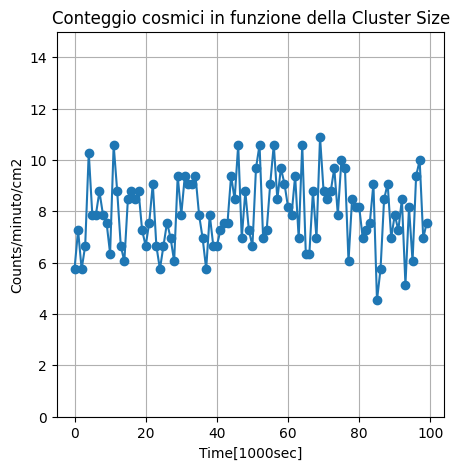

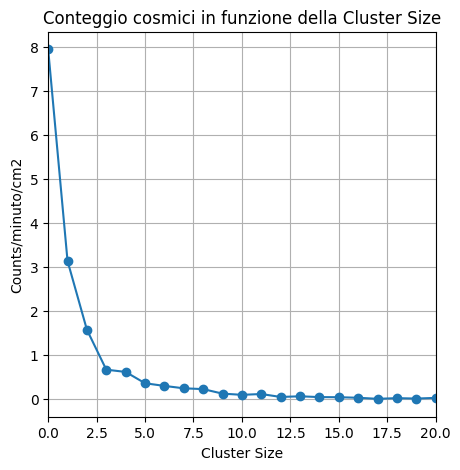

In [9]:
#Plot del vettore ClusterSize_Counts
plt.figure(figsize=(5, 5))
plt.plot(vector_Rate, marker='o')
plt.xlabel("Time[1000sec]")
plt.ylabel("Counts/minuto/cm2")
plt.title("Conteggio cosmici in funzione della Cluster Size")
plt.ylim(0,15)
plt.grid(True)
plt.show()

# prompt: genera il plot del vettore ClusterSize_Counts
ClusterSize_Counts_minuto_cm2 = ClusterSize_Counts/TimeAcq/Area * 60
#Plot del vettore ClusterSize_Counts
plt.figure(figsize=(5, 5))
plt.plot(ClusterSize_Counts_minuto_cm2, marker='o')
plt.xlabel("Cluster Size")
plt.ylabel("Counts/minuto/cm2")
plt.title("Conteggio cosmici in funzione della Cluster Size")
plt.xlim(0,20)
plt.grid(True)
plt.show()


In [10]:
print("Numero di clusters", Ncluster, "con fluttuazione attesa +/-",math.sqrt(Ncluster) )
print("Numero di clusters per Cluster Size",ClusterSize_Counts[:20])

print("Numero di clusters/sec/cm2",Ncluster/TimeAcq/Area, "con fluttuazione attesa +/-",math.sqrt(Ncluster)/TimeAcq/Area)
print("Numero di clusters/sec/cm2 per Cluster Size",ClusterSize_Counts[:20]/TimeAcq/Area)
print("Numero di clusters/min/cm2",Ncluster*60/TimeAcq/Area, "con fluttuazione attesa +/-",math.sqrt(Ncluster)*60/TimeAcq/Area)
print("Numero di clusters/min/cm2 per Cluster Size",ClusterSize_Counts[:20]*60/TimeAcq/Area)

Numero di clusters 2629 con fluttuazione attesa +/- 51.273774973177076
Numero di clusters per Cluster Size [2629. 1039.  522.  222.  205.  120.  100.   82.   76.   42.   33.   39.
   17.   22.   16.   15.   11.    3.    8.    5.]
Numero di clusters/sec/cm2 0.13261274857954547 con fluttuazione attesa +/- 0.0025863660057976884
Numero di clusters/sec/cm2 per Cluster Size [0.13261275 0.05240953 0.02633087 0.01119819 0.01034067 0.00605307
 0.00504423 0.00413627 0.00383361 0.00211858 0.0016646  0.00196725
 0.00085752 0.00110973 0.00080708 0.00075663 0.00055487 0.00015133
 0.00040354 0.00025221]
Numero di clusters/min/cm2 7.9567649147727275 con fluttuazione attesa +/- 0.1551819603478613
Numero di clusters/min/cm2 per Cluster Size [7.95676491 3.1445716  1.57985214 0.67189114 0.62044002 0.3631844
 0.30265367 0.24817601 0.23001679 0.12711454 0.09987571 0.11803493
 0.05145112 0.06658381 0.04842459 0.04539805 0.0332919  0.00907961
 0.02421229 0.01513268]


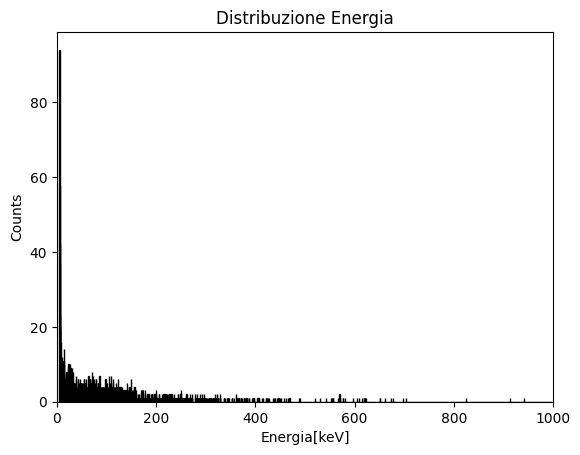

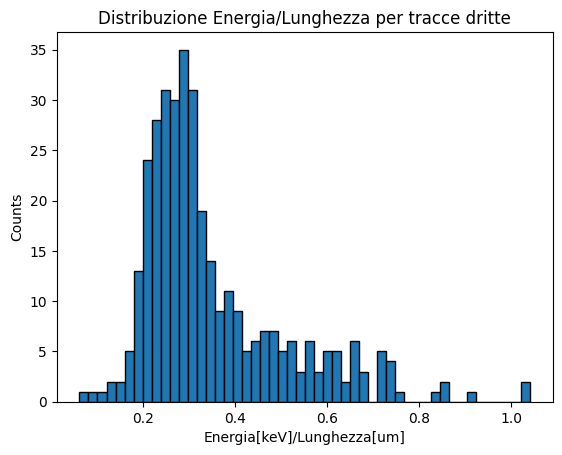

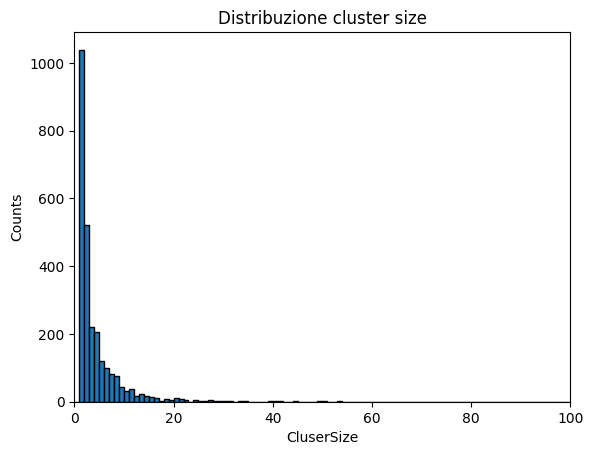

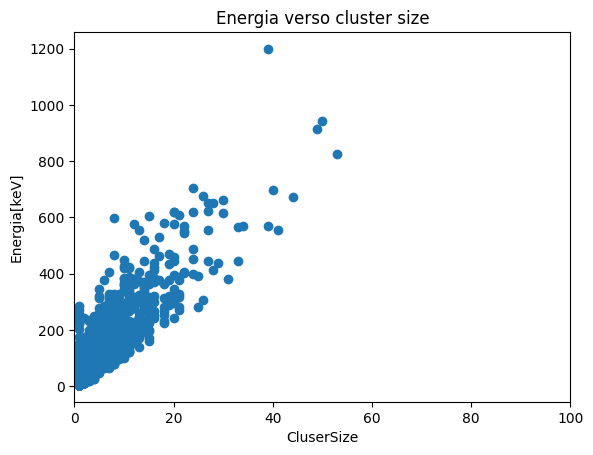

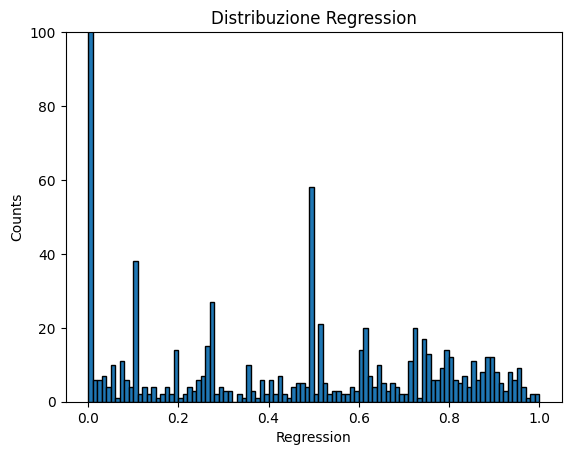

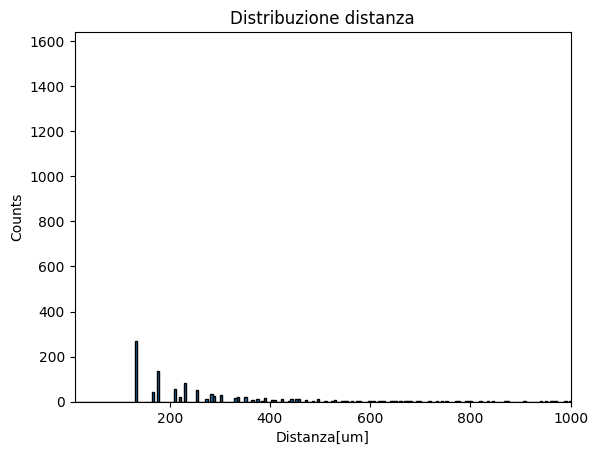

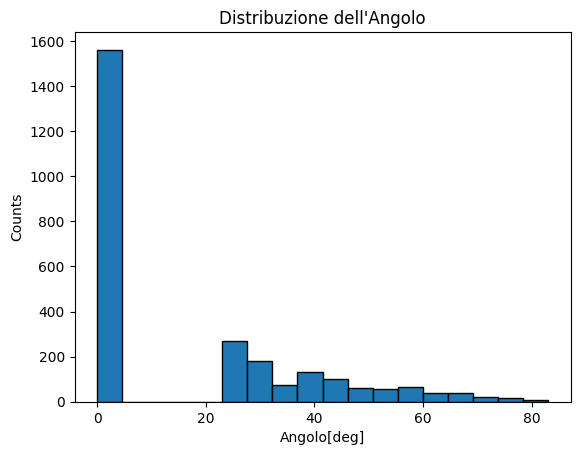

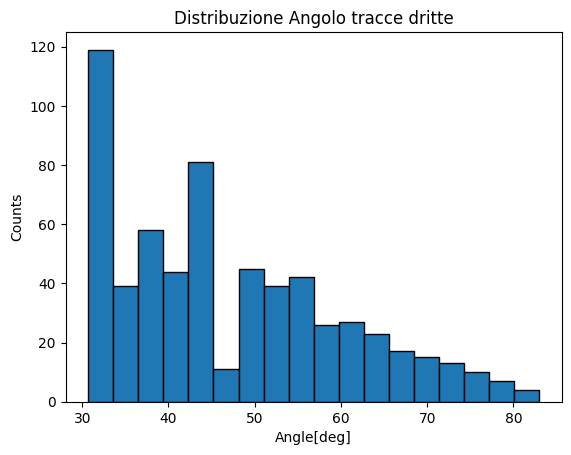

In [11]:


# Crea un istogramma del vettore
plt.hist(vector_Energia, bins=5000, edgecolor='black')
# Aggiungi etichette agli assi
plt.xlabel('Energia[keV]')
plt.ylabel('Counts')
# Aggiungi un titolo al grafico
plt.title('Distribuzione Energia')
plt.xlim(0,1000)
# Mostra il grafico
plt.show()

vector_Energiaperum_R = [vector_Energiaperum[i] for i in range(len(vector_Regression)) if vector_Regression[i]>0.5]
# Crea un istogramma del vettore
plt.hist(vector_Energiaperum_R, bins=50, edgecolor='black')
# Aggiungi etichette agli assi
plt.xlabel('Energia[keV]/Lunghezza[um]')
plt.ylabel('Counts')
# Aggiungi un titolo al grafico
plt.title('Distribuzione Energia/Lunghezza per tracce dritte')
#plt.xlim(0.1,2)
# Mostra il grafico
plt.show()

binInt=np.arange(0,1000)
# Crea un istogramma del vettore
plt.hist(vector_ClusterSize, bins=binInt, edgecolor='black')
# Aggiungi etichette agli assi
plt.xlabel('CluserSize')
plt.ylabel('Counts')
# Aggiungi un titolo al grafico
plt.title('Distribuzione cluster size')
plt.xlim(0,100)
# Mostra il grafico
plt.show()

# Crea un istogramma del vettore
plt.scatter(vector_ClusterSize, vector_Energia)
# Aggiungi etichette agli assi
plt.xlabel('CluserSize')
plt.ylabel('Energia[keV]')
# Aggiungi un titolo al grafico
plt.title('Energia verso cluster size')
plt.xlim(0,100)
# Mostra il grafico
plt.show()


# Crea un istogramma del vettore
plt.hist(vector_Regression, bins=100, edgecolor='black')
# Aggiungi etichette agli assi
plt.xlabel('Regression')
plt.ylabel('Counts')
# Aggiungi un titolo al grafico
plt.title('Distribuzione Regression')
plt.ylim(0.,100)
# Mostra il grafico
plt.show()

# Crea un istogramma del vettore
plt.hist(vector_Distanza, bins=500, edgecolor='black')
# Aggiungi etichette agli assi
plt.xlabel('Distanza[um]')
plt.ylabel('Counts')
# Aggiungi un titolo al grafico
plt.title('Distribuzione distanza')
plt.xlim(10,1000)
# Mostra il grafico
plt.show()

plt.hist(vector_Angolo, bins=18, edgecolor='black')
# Aggiungi etichette agli assi
plt.xlabel('Angolo[deg]')
plt.ylabel('Counts')
# Aggiungi un titolo al grafico
plt.title('Distribuzione dell\'Angolo')
#plt.xlim(0,5)
# Mostra il grafico
plt.show()


vector_Angolo_R = [vector_Angolo[i] for i in range(len(vector_Regression)) if vector_Regression[i]>0.1]
# Crea un istogramma del vettore
counts_and_bin_edges = plt.hist(vector_Angolo_R, bins=18, edgecolor='black')
# Aggiungi etichette agli assi
plt.xlabel('Angle[deg]')
plt.ylabel('Counts')
# Aggiungi un titolo al grafico
plt.title('Distribuzione Angolo tracce dritte')
#plt.xlim(0,1000)
# Mostra il grafico
plt.show()


